<a href="https://colab.research.google.com/github/genfaith/CV_with_Pytorch_using_Kaggle_Dataset/blob/main/CV_with_Pytorch_using_Kaggle_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from PIL import Image
from torch import optim

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
!pip install torch_summary

In [1]:
# !pip install -q kaggle
from google.colab import files
files.upload()

{}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [ ]:
train_data_dir = '/content/training_set/training_set'
test_data_dir = '/content/test_set/test_set'

In [ ]:
from torch.utils.data import DataLoader, Dataset

In [ ]:
class cats_dogs(Dataset):
  def __init__(self, folder):
    cats = glob(folder+'/cats/*.jpg')
    dogs = glob(folder+'/dogs/*.jpg')
    self.fpaths = cats + dogs

    # randomize the file paths and create target variables
    from random import shuffle, seed; seed(10);
    shuffle(self.fpaths)
    self.targets = [
        fpath.split('/')[-1].startswith('dog') \
        for fpath in self.fpaths
    ] # dog = 1

  def __len__(self):
    return len(self.fpaths)

  def __getitem__(self, ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im, (224,224))
    return torch.tensor(im/255).permute(2,0,1).to(device).float(), \
            torch.tensor([target]).float().to(device)

In [ ]:
data = cats_dogs(train_data_dir)
im, label = data[200]

tensor([1.], device='cuda:0')


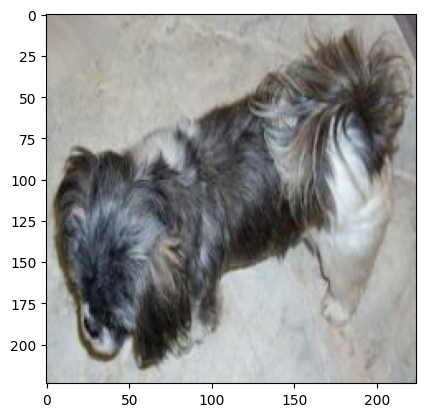

In [ ]:
# matplotlib expects the image in the order: height, width, channels

plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [ ]:
# model, loss fn, optimizer

def conv_layer(ni, no, kernel_size, stride=1):
  return nn.Sequential(
      nn.Conv2d(ni, no, kernel_size, stride),
      nn.ReLU(),
      nn.BatchNorm2d(no),
      nn.MaxPool2d(2)
  )

def get_model():
  model = nn.Sequential(
      conv_layer(3, 64, 3),
      conv_layer(64, 512, 3),

      conv_layer(512, 512, 3),
      conv_layer(512, 512, 3),
      conv_layer(512, 512, 3),
      conv_layer(512, 512, 3),
      nn.Flatten(),
      nn.Linear(512, 1),
      nn.Sigmoid(),
  ).to(device)

  loss_fn = nn.BCELoss() # binary cross entropy loss
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer

In [ ]:
from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, torch.zeros(1,3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 111, 111]        --
|    └─Conv2d: 2-1                       [-1, 64, 222, 222]        1,792
|    └─ReLU: 2-2                         [-1, 64, 222, 222]        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 222, 222]        128
|    └─MaxPool2d: 2-4                    [-1, 64, 111, 111]        --
├─Sequential: 1-2                        [-1, 512, 54, 54]         --
|    └─Conv2d: 2-5                       [-1, 512, 109, 109]       295,424
|    └─ReLU: 2-6                         [-1, 512, 109, 109]       --
|    └─BatchNorm2d: 2-7                  [-1, 512, 109, 109]       1,024
|    └─MaxPool2d: 2-8                    [-1, 512, 54, 54]         --
├─Sequential: 1-3                        [-1, 512, 26, 26]         --
|    └─Conv2d: 2-9                       [-1, 512, 52, 52]         2,359,808
|    └─ReLU: 2-10                        [-1, 512, 52, 52]        

In [ ]:
def get_data():
  train = cats_dogs(train_data_dir)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True, \
                      drop_last=True)
  val = cats_dogs(test_data_dir)
  val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last=True)
  return trn_dl, val_dl

In [ ]:
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  opt.step()
  opt.zero_grad()
  return batch_loss.item()

In [ ]:
@torch.no_grad()
def accuracy(x, y, model):
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [ ]:
@torch.no_grad()
def val_loss(x, y, model):
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

### Train the model for 5 epochs and check the accuracy

In [ ]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(5):
  train_epoch_losses, train_epoch_accuracies = [], []
  val_epoch_accuracies = []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()

  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    val_epoch_accuracies.extend(val_is_correct)
  val_epoch_accuracy = np.mean(val_epoch_accuracies)

  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracies.append(val_epoch_accuracy)

### Plot the variation of the training and validation accuracies over increasing epochs

<ipython-input-21-61573012827e>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([


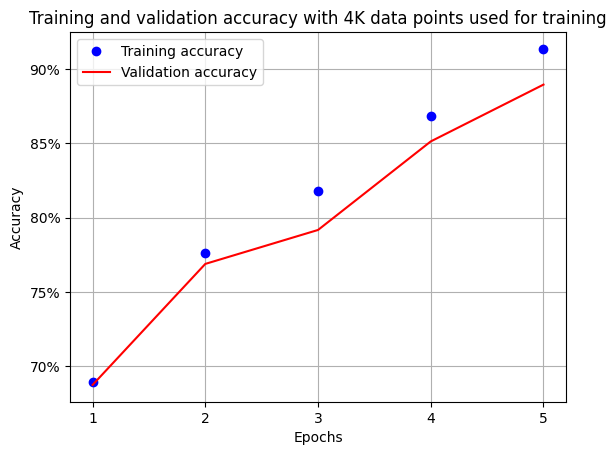

In [ ]:
epochs = np.arange(5)+1

import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline


plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 4K data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels([
    '{:.0f}%'.format(x*100) \
    for x in plt.gca().get_yticks()
])
plt.legend()
plt.grid('off')
plt.show()